# Анализ АА/Б теста

## Содержание

- **[Постановка задачи](#Постановка-задачи)**
- **[Описание данных](#Описание-данных)**
- **[Импорт библиотек и кастомные функции](#Импорт-библиотек-и-кастомные-функции)**
- **[1. Загрузка данных и EDA](#1.-Загрузка-данных-и-EDA)**
    - [1.1 Данные по пользователям из тестовой группы](#1.1-Данные-по-пользователям-из-тестовой-группым)
    - [1.2 Данные по транзакциям пользователей из тестовой группы](#1.2-Данные-по-транзакциям-пользователей-из-тестовой-группы)
    - [1.3 Данные по пользователям из 1-й контрольной группы](#1.3-Данные-по-пользователям-из-1-й-контрольной-группы)
    - [1.4 Данные по пользователям из 2-й контрольной группы](#1.4-Данные-по-пользователям-из-2-й-контрольной-группы)
    - [1.5 Данные по транзакциям пользователей из 1-й контрольной группы](#1.5-Данные-по-транзакциям-пользователей-из-1-й-контрольной-группы)
    - [1.6 Данные по транзакциям пользователей из 2-й контрольной группы](#1.5-Данные-по-транзакциям-пользователей-из-2-й-контрольной-группы)
- **[2. Проверка качества сплитования](#2.-Проверка-качества-сплитования)**
- **[3. Оценка результатов АА/Б теста](#3.-Оценка-результатов-АА/Б-теста)**
    - [3.1 Гипотеза о равенстве долей пользователей сделавших покупку](#3.1-Гипотеза-о-равенстве-долей-пользователей-сделавших-покупку)
    - [3.2 Гипотеза о равенстве долей пользователей оформивших премиум подписку](#3.2-Гипотеза-о-равенстве-долей-пользователей-оформивших-премиум-подписку)
    - [3.3 Гипотеза о равенстве ARPPU по всем продуктам](#3.3-Гипотеза-о-равенстве-ARPPU-по-всем-продуктам)
    - [3.4 Гипотеза о равенстве ARPPU по премиум подписке](#3.4-Гипотеза-о-равенстве-ARPPU-по-премиум-подписке)
    - [3.5 В поисках различий групп пользователей](#3.5-В-поисках-различий-групп-пользователей)
- **[4. Заключение](#4.-Заключение)**

<hr>

## Постановка задачи

Представьте, что вы работаете в крупном дейтинговом приложении. Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен AА/Б тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:
- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*

<hr>

## Описание данных

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:<br>
- `users_*.csv` – информация о пользователях:

| |                                                                               |
| :----------------| :-------------------------------------------------------------------------------------|
| uid              | идентификатор пользователя                                                            |
| age              | возраст                                                                               |
| attraction_coeff |  коэффициент привлекательности (от 0 до 1000, $\frac{лайки}{просмотры}*1000$ )        |
| coins            | число монеток (внутренняя валюта)                                                     |
| country          | страна                                                                                |
| visit_days       | в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)  |
| gender           | пол                                                                                   |
| age_filter_start | фильтр поиска, мин. значение                                                          |
| age_filter_end   | фильтр поиска, макс. значение                                                         |
| views_count      | число полученных оценок                                                               |
| was_premium      | был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)  |
| is_premium       | является ли премиум                                                                   |
| total_revenue    | нормированная выручка                                                                 |

- `transactions_*.csv` – информация о пользователях:

|                  |                                                                                       |
| :----------------| :-------------------------------------------------------------------------------------|
| uid              | идентификатор пользователя                                                            |
| country          | страна                                                                                |
| joined_at        | дата и время регистрации                                                              |
| paid_at          | дата и время покупки                                                                  |
| revenue          | нормированная выручка                                                                 |
| payment_id       | идентификатор платежа                                                                 |
| from_page        | откуда пользователь перешел на страницу оплаты                                        |
| product_type     | тип продукта (`trial_premium` – пробная премиум-подписка, `premium_no_trial` – премиум-подписка без пробной, `coins` – подписка за внутреннюю валюту, `other_type` – другое)                                   |

<hr>

## Импорт библиотек и кастомные функции

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels as sts
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_column', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Функция для визуализации % пропущенных значений в датасете
def plot_missing_values(df):
    """
        Функция возвращает барплот с процентом пропущенных значений в датасете
    """
    missing = df.isna().sum().sort_values(ascending=False)
    if missing.sum() > 0:
        missing = missing[missing > 0]
        missing_mean = df.isna().mean().sort_values(ascending=False) * 100
        fig, ax = plt.subplots(figsize=(10, 2))
        sns.barplot(missing, missing.index, palette='cool_r')
        sns.despine()
        plt.title('Number of missing values in features', fontsize=14)
        for i, value in enumerate(missing_mean):
            if value > 0:
                plt.text(missing.iloc[i], i, str(round(value, 2)) + '%', fontdict={'fontweight':200, 'size':12}, va='center')
    else:
        return f'There aren\'t any missing values'

In [3]:
# Функция возвращает количество пользователей продливших и не продливших подписку
def number_of_premium(df):
    """
        Функция возвращает количество пользователей продливших и не продливших подписку
    """
    is_premium = set(df[df.is_premium == True].uid.tolist())
    was_premium = set(df[df.was_premium == True].uid.tolist())
    not_canceled = len(is_premium) or len(is_premium.difference(was_premium))
    canceled = len(was_premium.difference(is_premium))
    print(f'Продлили премиум подписку - {not_canceled}.\n' \
          f'Пользовались, но не продлили премиум подписку - {canceled}.')

In [4]:
# Асимптотический тест для равенства средних
def asy_mean_test(mean_hat, std_hat, mu_0=0, alpha=0.05, alternative='two-sided', margin=3):
    """
        Асимптотический тест для равенства средних
    """
    z_obs = (mean_hat - mu_0)/std_hat
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)
        
        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'), 
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return f'p-value: {p_value:.3}'

In [5]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(data_col_1, data_col_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    """
        Бутстрапирование двух выборок. Функция возвращает значение p_value
    """
    boot_len = max([len(data_col_1), len(data_col_2)])
    boot_data = []
    for i in range(boot_it):
        sample_1 = data_col_1.sample(boot_len, replace=True).values
        sample_2 = data_col_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(sample_1 - sample_2))
        
        pd_boot_data = pd.DataFrame(boot_data)
        
        p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
        p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
        p_value = min(p_1, p_2) * 2
        
    return p_value

<hr>

## 1. Загрузка данных и EDA

In [6]:
# Загрузим все имеющиеся данные
users_test = pd.read_csv('datasets/dating_users_test.csv', sep=';')
users_control_1 = pd.read_csv('datasets\dating_users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('datasets\dating_users_control_2.csv', sep=';')
transactions_test = pd.read_csv('datasets\dating_transactions_test.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_1 = pd.read_csv('datasets\dating_transactions_control_1.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_2 = pd.read_csv('datasets\dating_transactions_control_2.csv', sep=';', parse_dates=['joined_at', 'paid_at'])

### 1.1 Данные по пользователям из тестовой группы

In [7]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [8]:
# Посмотрим на характеристики данных по пользователям
users_test.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [9]:
# Преобразуем некоторые переменные к строковому типу
users_test['country'] = users_test['country'].astype('str')
users_test['uid'] = users_test['uid'].astype('str')

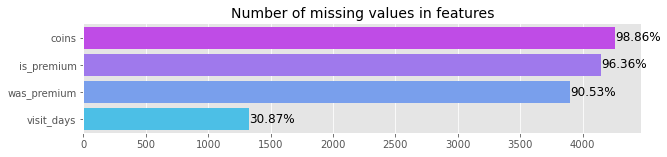

In [10]:
# Посмотрим на % пропущенных значений в данных
plot_missing_values(users_test)

У большей части пользователей отсутствуют данные по монетам, при этом большое количество данных по статусу премиум также отсутствует. Можно предположить, что эти пропуски в данных обусловлены тем, что основная масса клиентов не использует премиальную подписку и, соответственно, у таких клиентов  нет монет. Также частично отсутствуют данные по дням посещений.

In [11]:
# Посмотрим на значения в колонке is_premium
users_test['is_premium'].value_counts()

1.0    157
Name: is_premium, dtype: int64

Таким образом, пропущенные значения в колонках `is_premium` и `was_premium` свидетельствуют о том, что пользователь не имеет статуса премиум и никогда таким статусом не обладал. Заполним пропуски в этих колонках нулями. Значение `0` будет обозначать отсутствие премиум подписки.

In [12]:
users_test['is_premium'] = users_test.is_premium.fillna(0)
users_test['was_premium'] = users_test.was_premium.fillna(0)

In [13]:
# Посмотрим на описательную статистику
users_test.loc[:, ~users_test.columns.isin(['uid', 'is_premium', 'was_premium', 'gender'])].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,4308.0,31.89,10.25,16.0,25.0,30.0,38.00,99.0
attraction_coeff,4308.0,316.41,323.37,0.0,0.0,250.0,520.25,1000.0
coins,49.0,229.84,1205.82,1.0,4.0,9.0,72.00,8466.0
age_filter_start,4308.0,26.70,9.39,13.0,19.0,24.0,32.00,96.0
age_filter_end,4308.0,38.25,15.34,19.0,28.0,35.0,44.00,102.0
views_count,4308.0,50.39,318.68,0.0,1.0,6.0,22.00,12831.0
total_revenue,4308.0,534.08,4371.68,0.0,0.0,0.0,0.00,129870.0


In [14]:
# Посмотрим на описательную статистику по категориальным переменным
users_test.describe(include=['O']).T

,count,unique,top,freq
uid,4308,4308,891538020,1
country,4308,51,United States of America,1450
visit_days,2978,891,1,525


In [15]:
# Посмотрим есть ли дубликаты строк в датафрейме
users_test.duplicated().sum()

0

Посмотрим сколько пользователей, у которых была премиальная подписка продлили ее. А также сколько пользователей не продляли подписку.

In [16]:
number_of_premium(users_test)

Продлили премиум подписку - 157.
Пользовались, но не продлили премиум подписку - 251.


In [17]:
# Посмотрим на топ 10 стран по числу пользователей
users_test.country.value_counts()[:10].reset_index().rename(columns={'index': 'country', 'country': 'count'})

,country,count
0,United States of America,1450
1,Argentina,396
2,France,359
3,Italy,323
4,Spain,301
5,Chile,272
6,United Arab Emirates,226
7,Germany,209
8,United Kingdom (Great Britain),169
9,Canada,137


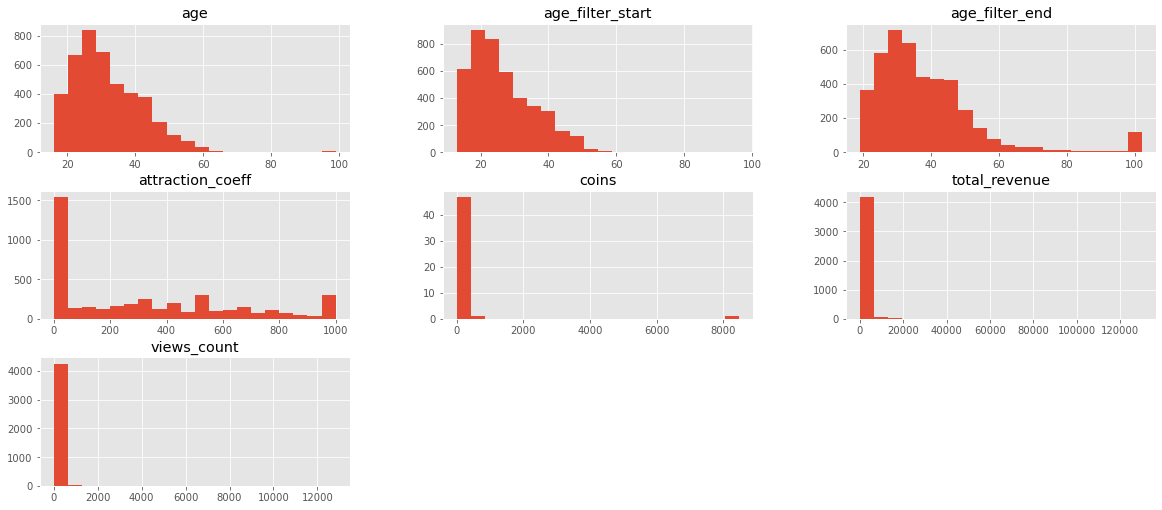

In [18]:
# Посмотрим на распределения количественных переменных
features = ['age', 'age_filter_start', 'age_filter_end', 'attraction_coeff', 'coins', 'total_revenue', 'views_count']
users_test[features].hist(figsize=(20, 8.5), layout=(3, 3), bins=20);

### 1.2 Данные по транзакциям пользователей из тестовой группы

In [19]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [20]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


In [21]:
# Преобразуем переменные к нужному типу
cols = [i for i in transactions_test.columns if transactions_test[i].dtype not in ['int64','datetime64[ns]'] 
        or i in ['uid', 'payment_id']]

for col in cols:
    transactions_test[col] = transactions_test[col].astype('str')

In [22]:
# Посмотрим есть ли дубликаты строк в датафрейме
transactions_test.duplicated().sum()

7

In [23]:
# Посмотрим на данные по которым есть дубликаты
transactions_test[transactions_test.duplicated() == 1]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
127,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
243,892339626,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754,19,empty_likes,coins


Возьмем первые два `uid` и посмотрим более детально.

In [24]:
transactions_test[transactions_test.uid == '892236423'][:4]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
17,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


In [25]:
transactions_test[transactions_test.uid == '892050108']

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
80,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
93,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:52:00,12597,147,left_sidebar_menu,premium_no_trial
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
212,892050108,Israel,2017-10-22 03:02:00,2017-10-23 04:50:00,1261,19,autorefill,coins


В данных действительно есть дубликаты.

In [26]:
# Удалим дубли
transactions_test.drop_duplicates(inplace=True)

In [27]:
# Посмотрим на описательную статистику
transactions_test.describe(datetime_is_numeric=True).round(2)

,joined_at,paid_at,revenue
count,266,266,266.00
mean,2017-09-05 04:54:23.909774592,2017-09-05 08:19:27.969926144,8767.77
min,2017-01-11 03:07:00,2017-01-11 04:37:00,533.00
25%,2017-08-11 03:54:00,2017-07-11 20:57:45,3129.75
50%,2017-10-18 20:34:00,2017-10-22 14:40:30,6363.50
75%,2017-10-23 13:08:00,2017-10-29 07:48:00,12597.00
max,2017-10-31 23:40:00,2017-12-11 22:06:00,113477.00
std,NaN,NaN,11216.24


Поскольку в условии сказано, что A/Б тест проводился для для новых пользователей из нескольких стран по `min` по `max` дате можно предположить что эксперимент продолжался `2017-01` по `2017-12`.

In [28]:
# Посмотрим на описательную статистику по категориальным переменным
transactions_test.describe(include=['O']).T

,count,unique,top,freq
uid,266,146,892236423,11
country,266,17,United States of America,89
payment_id,266,6,147,125
from_page,266,22,empty_likes,68
product_type,266,4,coins,101


Больше всего транзакций пришло из США, при этом самый активный пользователь с `id` - совершил 14 платежей.

In [29]:
# Посмотрим на уникальные значения product_type
transactions_test.product_type.unique().tolist()

['trial_premium', 'other_type', 'premium_no_trial', 'coins']

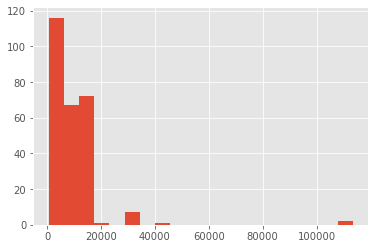

In [30]:
# Посмотрим на распределение по revenue
transactions_test.revenue.hist(bins=20);

### 1.3 Данные по пользователям из 1-й контрольной группы

In [31]:
# Посмотрим на характеристики данных по пользователям
users_control_1.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [32]:
# Преобразуем некоторые переменные к строковому типу
users_control_1['country'] = users_control_1['country'].astype('str')
users_control_1['uid'] = users_control_1['uid'].astype('str')

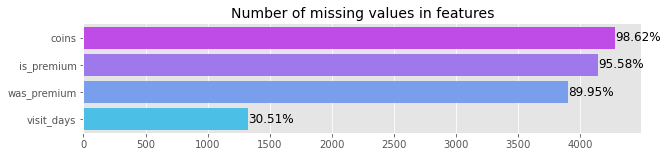

In [33]:
# Посмотрим на % пропущенных значений в данных
plot_missing_values(users_control_1)

In [34]:
# Заполним пропуски нулями в колонках is_premium и was_premium
users_control_1['is_premium'] = users_control_1.is_premium.fillna(0)
users_control_1['was_premium'] = users_control_1.was_premium.fillna(0)

In [35]:
# Посмотрим есть ли дубликаты строк в датафрейме
users_control_1.duplicated().sum()

0

In [36]:
# Посмотрим на описательную статистику
users_control_1.loc[:, ~users_control_1.columns.isin(['uid', 'is_premium', 'was_premium', 'gender'])].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,4340.0,32.10,10.26,16.0,24.0,30.0,38.0,99.0
attraction_coeff,4340.0,312.05,320.97,0.0,0.0,238.5,518.0,1000.0
coins,60.0,1745.90,12902.36,1.0,8.0,11.5,28.0,99958.0
age_filter_start,4340.0,26.79,9.41,13.0,19.0,25.0,32.0,96.0
age_filter_end,4340.0,38.55,15.23,19.0,28.0,35.0,45.0,102.0
views_count,4340.0,44.47,204.80,0.0,1.0,6.0,21.0,4953.0
total_revenue,4340.0,594.76,7987.92,0.0,0.0,0.0,0.0,486330.0


In [37]:
# Посмотрим на описательную статистику по категориальным переменным
users_control_1.describe(include=['O']).T

,count,unique,top,freq
uid,4340,4340,892127706,1
country,4340,40,United States of America,1471
visit_days,3016,880,1,592


Посмотрим сколько пользователей, у которых была премиальная подписка продлили ее. А также сколько пользователей не продляли подписку.

In [38]:
number_of_premium(users_control_1)

Продлили премиум подписку - 192.
Пользовались, но не продлили премиум подписку - 244.


In [39]:
# Посмотрим на топ 10 стран по числу пользователей
users_control_1.country.value_counts()[:10].reset_index().rename(columns={'index': 'country', 'country': 'count'})

,country,count
0,United States of America,1471
1,Argentina,389
2,France,370
3,Spain,342
4,Italy,338
5,Chile,287
6,United Arab Emirates,207
7,Germany,188
8,United Kingdom (Great Britain),146
9,Canada,134


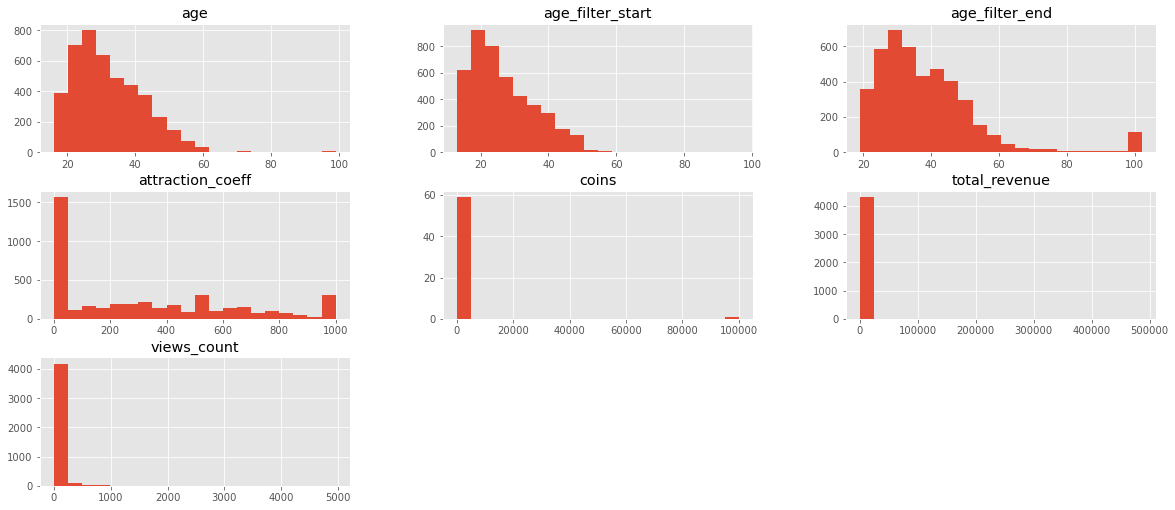

In [40]:
# Посмотрим на распределения количественных переменных
features = ['age', 'age_filter_start', 'age_filter_end', 'attraction_coeff', 'coins', 'total_revenue', 'views_count']
users_control_1[features].hist(figsize=(20, 8.5), layout=(3, 3), bins=20);

### 1.4 Данные по пользователям из 2-й контрольной группы

In [41]:
# Посмотрим на характеристики данных по пользователям
users_control_2.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [42]:
# Преобразуем некоторые переменные к строковому типу
users_control_2['country'] = users_control_2['country'].astype('str')
users_control_2['uid'] = users_control_2['uid'].astype('str')

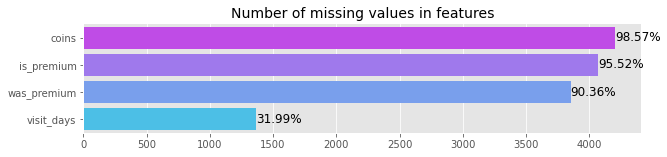

In [43]:
# Посмотрим на % пропущенных значений в данных
plot_missing_values(users_control_2)

In [44]:
# Заполним пропуски нулями в колонках is_premium и was_premium
users_control_2['is_premium'] = users_control_2.is_premium.fillna(0)
users_control_2['was_premium'] = users_control_2.was_premium.fillna(0)

In [45]:
# Посмотрим есть ли дубликаты строк в датафрейме
users_control_2.duplicated().sum()

0

In [46]:
# Посмотрим на описательную статистику
users_control_2.loc[:, ~users_control_2.columns.isin(['uid', 'is_premium', 'was_premium', 'gender'])].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,4264.0,32.05,10.17,16.0,25.0,30.0,38.0,99.0
attraction_coeff,4264.0,317.96,326.19,0.0,0.0,250.0,548.5,1000.0
coins,61.0,18.15,35.44,1.0,4.0,10.0,20.0,271.0
age_filter_start,4264.0,26.95,9.55,13.0,19.0,25.0,32.0,94.0
age_filter_end,4264.0,38.91,15.96,19.0,28.0,35.0,45.0,99.0
views_count,4264.0,45.06,318.19,0.0,1.0,6.0,20.0,16157.0
total_revenue,4264.0,450.38,2859.24,0.0,0.0,0.0,0.0,81796.0


In [47]:
# Посмотрим на описательную статистику по категориальным переменным
users_control_2.describe(include=['O']).T

,count,unique,top,freq
uid,4264,4264,892367289,1
country,4264,45,United States of America,1486
visit_days,2900,837,1,587


Посмотрим сколько пользователей, у которых была премиальная подписка продлили ее. А также сколько пользователей не продляли подписку.

In [48]:
number_of_premium(users_control_2)

Продлили премиум подписку - 191.
Пользовались, но не продлили премиум подписку - 220.


In [49]:
# Посмотрим на топ 10 стран по числу пользователей
users_control_2.country.value_counts()[:10].reset_index().rename(columns={'index': 'country', 'country': 'count'})

,country,count
0,United States of America,1486
1,Argentina,397
2,France,376
3,Spain,310
4,Italy,293
5,Chile,286
6,United Arab Emirates,211
7,Germany,202
8,United Kingdom (Great Britain),146
9,Canada,134


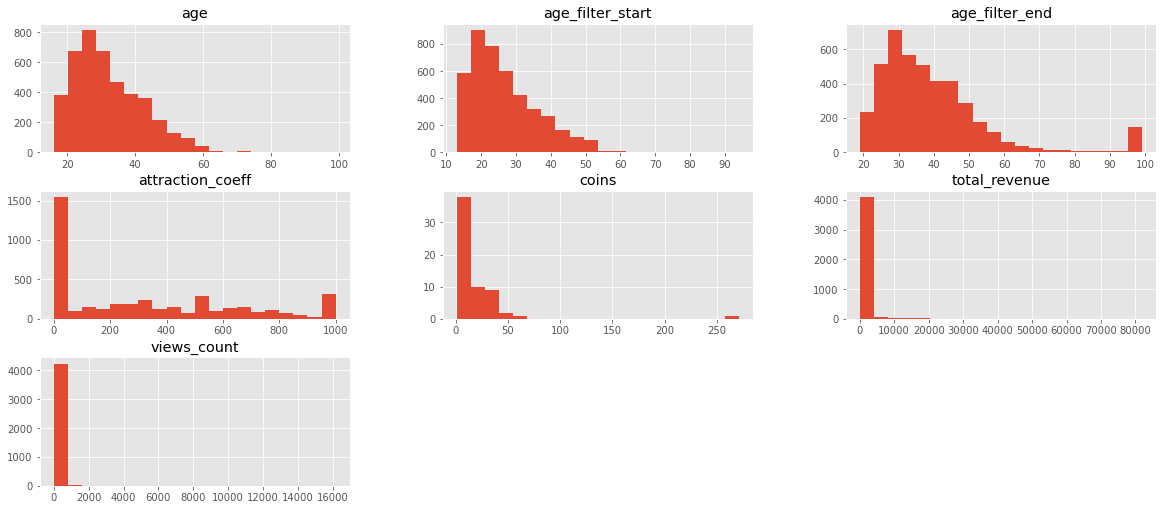

In [50]:
# Посмотрим на распределения количественных переменных
features = ['age', 'age_filter_start', 'age_filter_end', 'attraction_coeff', 'coins', 'total_revenue', 'views_count']
users_control_2[features].hist(figsize=(20, 8.5), layout=(3, 3), bins=20);

### 1.5 Данные по транзакциям пользователей из 1-й контрольной группы

In [51]:
# Посмотрим на характеристики данных
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


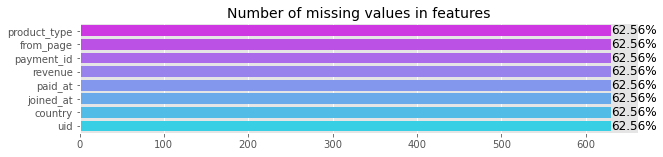

In [52]:
# Посмотрим на % пропущенных значений в данных
plot_missing_values(transactions_control_1)

In [53]:
# Удалим пустые строки в данных
transactions_control_1 = transactions_control_1.dropna()

In [54]:
# Преобразуем переменные к нужному типу
cols = ['uid', 'country', 'payment_id', 'from_page', 'product_type']

for col in cols:
    if col in ['uid', 'payment_id']:
        transactions_control_1[col] = transactions_control_1[col].astype('int64')
        transactions_control_1[col] = transactions_control_1[col].astype('str')
    else:
        transactions_control_1[col] = transactions_control_1[col].astype('str')

In [55]:
# Посмотрим есть ли дубликаты строк в датафрейме
transactions_control_1.duplicated().sum()

21

In [56]:
# Удалим дубли
transactions_control_1.drop_duplicates(inplace=True)

In [57]:
# Посмотрим на описательную статистику
transactions_control_1.describe(datetime_is_numeric=True).round(2)

,joined_at,paid_at,revenue
count,356,356,356.00
mean,2017-08-21 21:52:31.685394688,2017-09-03 23:56:06.067415296,7007.88
min,2015-01-19 11:49:00,2016-12-14 16:16:00,26.00
25%,2017-06-11 17:41:45,2017-07-11 11:56:15,2804.75
50%,2017-10-17 03:36:00,2017-10-17 10:34:30,6292.00
75%,2017-10-23 12:14:30,2017-10-28 05:51:45,7312.50
max,2017-10-31 22:17:00,2017-12-11 21:57:00,63037.00
std,NaN,NaN,7986.00


In [58]:
# Посмотрим на описательную статистику по категориальным переменным
transactions_control_1.describe(include=['O']).T

,count,unique,top,freq
uid,356,193,892333905,19
country,356,18,United States of America,100
payment_id,356,7,147,155
from_page,356,25,empty_likes,90
product_type,356,4,coins,137


In [59]:
# Посмотрим на уникальные значения product_type
transactions_control_1.product_type.unique().tolist()

['trial_premium', 'coins', 'other_type', 'premium_no_trial']

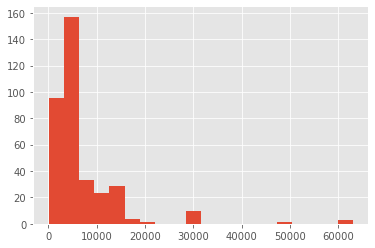

In [60]:
# Посмотрим на распределение по revenue
transactions_control_1.revenue.hist(bins=20);

### 1.6 Данные по транзакциям пользователей из 2-й контрольной группы

In [61]:
# Посмотрим на характеристики данных
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


In [62]:
# Посмотрим на % пропущенных значений в данных
plot_missing_values(transactions_control_1)

"There aren't any missing values"

In [63]:
# Преобразуем переменные к нужному типу
cols = [i for i in transactions_control_2.columns if transactions_control_2[i].dtype not in ['int64','datetime64[ns]'] 
        or i in ['uid', 'payment_id']]

for col in cols:
    transactions_control_2[col] = transactions_control_2[col].astype('str')

In [64]:
# Посмотрим есть ли дубликаты строк в датафрейме
transactions_control_2.duplicated().sum()

5

In [65]:
# Удалим дубли
transactions_control_2.drop_duplicates(inplace=True)

In [66]:
# Посмотрим на описательную статистику
transactions_control_2.describe(datetime_is_numeric=True).round(2)

,joined_at,paid_at,revenue
count,323,323,323.00
mean,2017-09-18 19:07:11.702786816,2017-09-03 21:10:33.250774784,5907.11
min,2017-01-11 08:36:00,2017-01-11 05:34:00,481.00
25%,2017-10-11 11:45:00,2017-07-11 11:45:00,2340.00
50%,2017-10-20 14:49:00,2017-10-21 20:12:00,4719.00
75%,2017-10-26 01:52:30,2017-10-28 10:42:30,6350.50
max,2017-10-31 17:43:00,2017-12-11 23:28:00,81796.00
std,NaN,NaN,6615.18


In [67]:
# Посмотрим на описательную статистику по категориальным переменным
transactions_control_2.describe(include=['O']).T

,count,unique,top,freq
uid,323,187,891637005,11
country,323,19,United States of America,105
payment_id,323,6,147,145
from_page,323,18,empty_likes,96
product_type,323,4,coins,120


In [68]:
# Посмотрим на уникальные значения product_type
transactions_control_2.product_type.unique().tolist()

['coins', 'premium_no_trial', 'trial_premium', 'other_type']

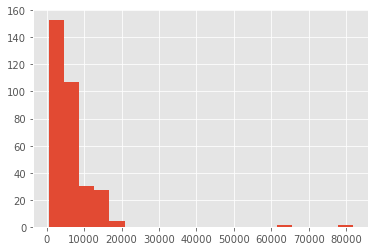

In [69]:
# Посмотрим на распределение по revenue
transactions_control_2.revenue.hist(bins=20);

<hr>

## 2. Проверка качества сплитования

__Предположим__, что исследуемые выборки являются независимыми друг от друга. Удостоверимся, что пользователи из одной выборки не встречаются в других выборках.

In [70]:
# Создадим для каждой выборки множества уникальных пользователей
test = set(users_test.uid.tolist())
control1 = set(users_control_1.uid.tolist())
control2 = set(users_control_2.uid.tolist())

test_t = set(transactions_test.uid.tolist())
control1_t = set(transactions_control_1.uid.tolist())
control2_t = set(transactions_control_2.uid.tolist())

# Проверим, есть ли пересечения множеств
print(test.intersection(control1), test.intersection(control2), control1.intersection(control2))
print(test_t.intersection(control1_t), test_t.intersection(control2_t), control1_t.intersection(control2_t))
print('=' * 25)

# Проверим, есть ли разница множеств пользователей в данных по транзакциям и общими данными по группам
test_r = set(users_test[users_test.total_revenue > 0].uid.tolist())
control1_r = set(users_control_1[users_control_1.total_revenue > 0].uid.tolist())
control2_r = set(users_control_2[users_control_2.total_revenue > 0].uid.tolist())
print(test_t.difference(test_r), control1_t.difference(control1_r), control2_t.difference(control2_r))

set() set() set()
set() set() set()
set() {'892355163'} set()


Посмотрим на пользователя `892355163` в двух датасетах.

In [71]:
display(users_control_1[users_control_1.uid == '892355163'])
display(transactions_control_1[transactions_control_1.uid == '892355163'])

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
3370,892355163,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,0.0,0


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
303,892355163,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68,super_popup,other_type


<br>
Проверим совпадают ли общие суммы покупок в данных.

In [72]:
pd.DataFrame({
    'group': ['test', 'control 1', 'control 2'],
    'full_data': [users_test.total_revenue.sum(), users_control_1.total_revenue.sum(), users_control_2.total_revenue.sum()],
    'transactions': [transactions_test.revenue.sum(), transactions_control_1.revenue.sum(), transactions_control_2.revenue.sum()]
})

,group,full_data,transactions
0,test,2300818,2332226.0
1,control 1,2581267,2494804.0
2,control 2,1920438,1907997.0


Исправим суммы по транзакциям в датасетах.

In [73]:
# Сагрегируем данные по пользователям
t0 = transactions_test.groupby(['uid'], as_index=False).agg({'revenue': 'sum'})
t1 = transactions_control_1.groupby(['uid'], as_index=False).agg({'revenue': 'sum'})
t2 = transactions_control_2.groupby(['uid'], as_index=False).agg({'revenue': 'sum'})

# Перезапишем данные по пользователям
users_test = users_test.merge(t0, on='uid', how='left') \
                        .drop(columns=['total_revenue']) \
                        .rename(columns={'revenue': 'total_revenue'})
users_test['total_revenue'] = users_test['total_revenue'].fillna(0)


users_control_1 = users_control_1.merge(t1, on='uid', how='left') \
                        .drop(columns=['total_revenue']) \
                        .rename(columns={'revenue': 'total_revenue'})
users_control_1['total_revenue'] = users_control_1['total_revenue'].fillna(0)


users_control_2 = users_control_2.merge(t2, on='uid', how='left') \
                        .drop(columns=['total_revenue']) \
                        .rename(columns={'revenue':'total_revenue'})
users_control_2['total_revenue'] = users_control_2['total_revenue'].fillna(0)

In [74]:
pd.DataFrame({
    'group': ['test', 'control 1', 'control 2'],
    'full_data': [users_test.total_revenue.sum(), users_control_1.total_revenue.sum(), users_control_2.total_revenue.sum()],
    'transactions': [transactions_test.revenue.sum(), transactions_control_1.revenue.sum(), transactions_control_2.revenue.sum()]
})

,group,full_data,transactions
0,test,2332226.0,2332226.0
1,control 1,2494804.0,2494804.0
2,control 2,1907997.0,1907997.0


Посмотрим как распределены пропорции по выборкам

In [75]:
# Доля пользователей совершивших покупку
pr_t = round(users_test[users_test.total_revenue > 0].shape[0] / users_test.shape[0] * 100, 2)
pr_c1 = round(users_control_1[users_control_1.total_revenue > 0].shape[0] / users_control_1.shape[0] * 100, 2)
pr_c2 = round(users_control_2[users_control_2.total_revenue > 0].shape[0] / users_control_2.shape[0] * 100, 2)

# Доля пользователей с премиум подпиской
pp_t = round(users_test[users_test.is_premium == 1].shape[0] / users_test.shape[0] * 100, 2)
pp_c1 = round(users_control_1[users_control_1.is_premium == 1].shape[0] / users_control_1.shape[0] * 100, 2)
pp_c2 = round(users_control_2[users_control_2.is_premium == 1].shape[0] / users_control_2.shape[0] * 100, 2)


# Распределение по полу
pg_t = dict(zip(users_test.gender.value_counts(normalize=True).round(2).index,
                users_test.gender.value_counts(normalize=True).round(2).values))
pg_c1 = dict(zip(users_control_1.gender.value_counts(normalize=True).round(2).index,
                users_control_1.gender.value_counts(normalize=True).round(2).values))
pg_c2 = dict(zip(users_control_2.gender.value_counts(normalize=True).round(2).index,
                users_control_2.gender.value_counts(normalize=True).round(2).values))

# Итоговый датафрейм
pd.DataFrame({'group': ['test', 'control 1', 'control 2'],
              'group_size': [users_test.shape[0], users_control_1.shape[0], users_control_2.shape[0]],
              'percent_revenue': [pr_t, pr_c1, pr_c2],
              'percent_is_premium': [pp_t, pp_c1, pp_c2],
              'percent_gender': [pg_t, pg_c1, pg_c2],
              'mean_users_age': [users_test.age.mean(), users_control_1.age.mean(), users_control_2.age.mean()],
              'paid_at_min': [transactions_test.paid_at.min().date(), transactions_control_1.paid_at.min().date(), transactions_control_2.paid_at.min().date()],
              'paid_at_max': [transactions_test.paid_at.max().date(), transactions_control_1.paid_at.max().date(), transactions_control_2.paid_at.max().date()]})

,group,group_size,percent_revenue,percent_is_premium,percent_gender,mean_users_age,paid_at_min,paid_at_max
0,test,4308,3.39,3.64,"{1: 0.95, 0: 0.05}",31.889276,2017-01-11,2017-12-11
1,control 1,4340,4.45,4.42,"{1: 0.96, 0: 0.04}",32.095392,2016-12-14,2017-12-11
2,control 2,4264,4.39,4.48,"{1: 0.95, 0: 0.05}",32.046201,2017-01-11,2017-12-11


> **Таким образом, анализ качества сплитования позволяет сделать вывод, что в исследуемых выборках соблюдаются пропорции в разрезе по ряду характеристик. При этом одни и те же пользователи не встречаются в различных выборках.**

<hr>

## 3.  Оценка результатов АА/Б теста

### 3.1 Гипотеза о равенстве долей пользователей сделавших покупку

Проверим гипотезу о том, что доля пользователей совершивших, покупку в тестовой группе равна доле пользователей, совершивших покупку как в первой, так и во второй контрольных группах против альтернативы, что в тестовой группе доля покупок изменилась:

\begin{equation*}
\begin{aligned} 
& H_0: p_{t} = p_{c1} = p_{c2}  \\
& H_a: \text{в тестовой группе вероятность совершения покупки отличается}  
\end{aligned}
\end{equation*}


Посколькy выборки у нас независимы, наблюдений много, воспользуемся ЦПТ, в соотствии с которой:

\begin{equation*}
\begin{aligned} 
& H_{0}: p_x = p_{y} \\
& H_{a}: p_x \ne p_{y}
\end{aligned}
\end{equation*}

Критерий для проверки: <br>
$$ 
z = \frac{p_x - p_y}{\sqrt{P(1 - P) \cdot \left(\frac{1}{n_x} + \frac{1}{n_y}\right)}} \overset{asy} {\sim} N (0, 1)
$$

Дисперсия $P$ при верности нулевой гипотезы - общая доля успехов в двух выборках:<br>
$$
P = \frac{m_x + m_y}{n_x + n_y}
$$

Для проверки гипотез воспользуемся пакетом из `statsmodels` `proportions_ztest`

In [76]:
# Промежуточные переменные
n_t = users_test.shape[0]
m_t = users_test[users_test.total_revenue > 0].shape[0]

n_c1 = users_control_1.shape[0]
m_c1 = users_control_1[users_control_1.total_revenue > 0].shape[0]

n_c2 = users_control_2.shape[0]
m_c2 = users_control_2[users_control_2.total_revenue > 0].shape[0]

# Датафрейм с долями
display(pd.DataFrame({'group': ['test', 'control 1', 'control 2'],
                      'purchases_num': [m_t, m_c1, m_c2],
                      'all_users': [n_t, n_c1, n_c2],
                      'proportion' : [round(m_t/n_t, 4), round(m_c1/n_c1, 4), round(m_c2/n_c2, 4)]}))


# Проверка гипотез
_, p1 =  proportions_ztest((m_t, m_c1), 
                           (n_t, n_c1), 
                           value=0, 
                           alternative='two-sided')

_, p2 =  proportions_ztest((m_t, m_c2), 
                           (n_t, n_c2), 
                           value=0, 
                           alternative='two-sided')

_, p3 =  proportions_ztest((m_c1, m_c2), 
                           (n_c1, n_c2), 
                           value=0, 
                           alternative='two-sided')

# Поправка Холма на множественное сравнение 
rejected, p_corrected, _, _ = multipletests([p1, p2, p3], alpha=0.05, method='holm')
print(f'p-values: {p_corrected[0]:.3}, {p_corrected[1]:.3}, {p_corrected[2]:.3}')

,group,purchases_num,all_users,proportion
0,test,146,4308,0.0339
1,control 1,193,4340,0.0445
2,control 2,187,4264,0.0439


p-values: 0.0338, 0.0339, 0.89


> __Первые две гипотезы о равенстве долей (вероятности совершения покупки) на 5% уровне значимости отвергаются. Гипотеза о равенстве долей в 1-й и 2-й контрольных группах на 5% уровне значимости не отвергаются. Таким образом доля пользователей совершивших покупку как в 1-й контрольной группе, так и во 2-й отличается от доли пользователей совершивших покупку в тестовой группе.__

Проверим односторонние гипотезы:

\begin{equation*}
\begin{aligned} 
& H_0: p_{t} = p_{c1}  \\
& H_a: p_{t} < p_{c1}
\\
\\
& H_0: p_{t} = p_{c2}  \\
& H_a: p_{t} < p_{c2}
\end{aligned}
\end{equation*}

In [77]:
# Проверка гипотез
p_values = []

for m, n in zip([m_c1, m_c2], [n_c1, n_c2]):
    _, p = proportions_ztest((m_t, m), (n_t, n), value=0, alternative='smaller')
    p_values.append(p)

# Поправка Холма на множественное сравнение 
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')
print(f'p-values: {p_corrected[0]:.3}, {p_corrected[1]:.3}')

p-values: 0.0113, 0.0113


> __Нулевая гипотеза на 5% уровне значимости отвергается, принимается альтернативная - доля пользователей совершивших покупку в тестовой группе снизилась по сравнению с долей пользователей как в 1-й контрольной группе, так и во 2-й контрольной группе.__

### 3.2 Гипотеза о равенстве долей пользователей оформивших премиум подписку

Проверим гипотезу о том, что доля пользователей оформивших премиум подписку в тестовой группе равна доле пользователей, оформивших премиум подписку как в первой, так и во второй контрольных группах против альтернативы, что в тестовой группе доля оформивших премиум подписку изменилась:

\begin{equation*}
\begin{aligned} 
& H_0: p_{t} = p_{c1} = p_{c2}  \\
& H_a: \text{в тестовой группе доля оформивших премиум подписку отличается}  
\end{aligned}
\end{equation*}

<br>

Воспользуемся ЦПТ и пакетом `proportions_ztest` из `statsmodels`

In [78]:
# Промежуточные переменные
tt_m = transactions_test[transactions_test.product_type == 'trial_premium'].uid.nunique()
tt_n = transactions_test.uid.nunique()

ttc1_m = transactions_control_1[transactions_control_1.product_type == 'trial_premium'].uid.nunique()
ttc1_n = transactions_control_1.uid.nunique()

ttc2_m = transactions_control_2[transactions_control_2.product_type == 'trial_premium'].uid.nunique()
ttc2_n = transactions_control_2.uid.nunique()

# Датафрейм с долями
display(pd.DataFrame({'group': ['test', 'control 1', 'control 2'],
                      'trial_premium_size': [tt_m, ttc1_m, ttc2_m],
                      'unique_users_count': [tt_n, ttc1_n, ttc2_n],
                      'proportion' : [round(tt_m/tt_n, 3), round(ttc1_m/ttc1_n, 3), round(ttc2_m/ttc2_n, 3)]}))

# Проверка гипотез
_, p1 =  proportions_ztest((tt_m, ttc1_m), 
                           (tt_n, ttc1_n), 
                           value=0, 
                           alternative='two-sided')

_, p2 =  proportions_ztest((tt_m, ttc2_m), 
                           (tt_n, ttc2_n), 
                           value=0, 
                           alternative='two-sided')

_, p3 =  proportions_ztest((ttc1_m, ttc2_m), 
                           (ttc1_n, ttc2_n), 
                           value=0, 
                           alternative='two-sided')

# Поправка Холма на множественное сравнение 
rejected, p_corrected, _, _ = multipletests([p1, p2, p3], alpha=0.05, method='holm')
print(f'p-values: {p_corrected[0]:.3}, {p_corrected[1]:.3}, {p_corrected[2]:.3}')

,group,trial_premium_size,unique_users_count,proportion
0,test,61,146,0.418
1,control 1,67,193,0.347
2,control 2,53,187,0.283


p-values: 0.363, 0.031, 0.363


> Таким образом:
    > - нулевая гипотеза о равенстве долей пользователей оформивших премиум подписку в тестовой группе и 1-й контрольной на 5% уровне значимости не отвергается;
    > - нулевая гипотеза о равенстве долей пользователей оформивших премиум подписку в тестовой группе и 2-й контрольной группе на 5%  уровне значимости отвергается - **между этим группами есть разница**;
    > - нулевая гипотеза о равенстве долей пользователей оформивших премиум подписку в 1-й контрольной группе и 2-й контрольной на 5% уровне значимости не отвергается.
    
<br>
Проверим односторонню гипотезу:

\begin{equation*}
\begin{aligned} 
& H_0: p_{t} \le p_{c2}  \\
& H_a: p_{t} > p_{c2}
\end{aligned}
\end{equation*}

In [79]:
_, p =  proportions_ztest((tt_m, ttc2_m), 
                           (tt_n, ttc2_n), 
                           value=0, 
                           alternative='larger')

print(f'p-value: {p:.3}')

p-value: 0.00517


Гипотеза о равенсве долей отвергается на 5%  уровне значимости.
<br>

Построим асимптотический доверительный интервал для разности долей между тестовой группой и 2-й контрольной.

In [80]:
p1, p2 = tt_m/tt_n, ttc2_m/ttc2_n

p1_hat = p1 * (1 - p1)
p2_hat = p2 * (1 - p2)

diff = p1 - p2
diff_std = np.sqrt(p1_hat/tt_n + p2_hat/ttc2_n)

left, right = stats.norm.interval(0.95, loc=diff, scale=diff_std)
delta = right - left

print(f"Доверительный интервал [{left:.2%}; {right:.2%}] ширины {delta:.2%}")

Доверительный интервал [3.16%; 23.72%] ширины 20.56%


>**На основании результатов проверки гипотезы 3.2 можно сделать вывод, что доля пользователей оформивших премиум подписку в тестовой группе не изменилась по сравнению с 1-й контрольной группой, но `увеличилась` по сравнению со 2-й контрольной группой.**
>
>**Доля пользователей оформивших премиум подписку в тестовой группе отличается от доли пользвателей оформивших премиум подписку во 2-й контрольной группе на величину лежащую в диапозоне от 3.16% до 23.72%.**

### 3.3 Гипотеза о равенстве ARPPU по всем продуктам
<br>

Посмотрим на средние значения `total_revenue` в исследуемых выборках.

In [81]:
# Отфильтруем данные 
x_full = users_test[users_test.total_revenue > 0]
y_full = users_control_1[users_control_1.total_revenue > 0]
z_full = users_control_2[users_control_2.total_revenue > 0]


pd.DataFrame({'group': ['test', 'control_1', 'control_2'],
              'mean_revenue': list(map(round, [x_full.total_revenue.mean(),
                                               y_full.total_revenue.mean(),
                                               z_full.total_revenue.mean()]))
             })

,group,mean_revenue
0,test,15974
1,control_1,12926
2,control_2,10203


Посмотрим с помощью боксплот на распределение `total_revenue` в исследуемых выборках.

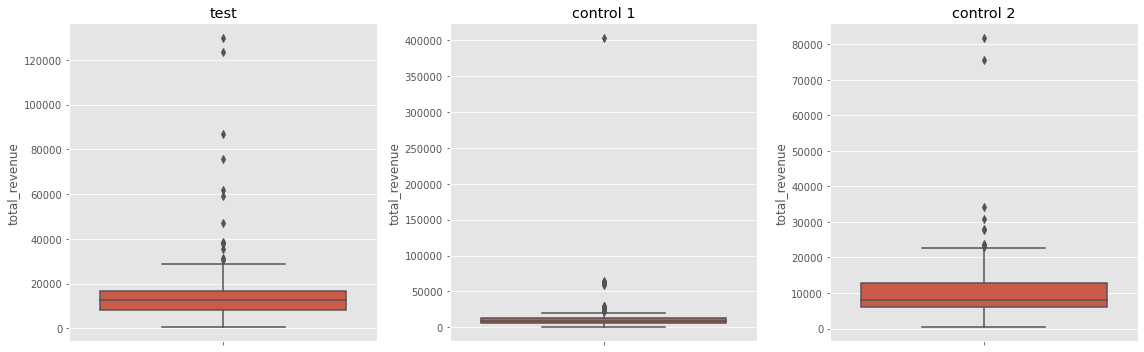

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

for ax, data, title in zip(ax.flatten(), [x_full, y_full, z_full], ['test', 'control 1', 'control 2']):
    sns.boxplot(data=data, y='total_revenue', ax=ax)
    ax.set(title=title)
plt.tight_layout();

Из распределений видно, что в трех исследуемых выборках имеются выбросы. При этом в контрольной выборке из первой группы имеется очень существенный выброс со значением $ > 400,000$ ден. единиц.
Проверим формально наши выборки на нормальность распределения. Для этого воспользуемся тестом Колмогорова-Смирнова.

In [83]:
ks_pvals = {}
for data, name in zip([x_full, y_full, z_full], ['test', 'control 1', 'control 2']):
    res = stats.kstest(data.total_revenue, 'norm', args=(data.total_revenue.mean(), data.total_revenue.std(ddof=1)))[-1]
    ks_pvals[name] = res
print(ks_pvals)

{'test': 4.771009847320826e-10, 'control 1': 1.6571187750125733e-21, 'control 2': 1.2681949255705835e-06}


Данные в исследуемых выборках **не** распределены нормально. Для проверки гипотезы 3.3, можно воспользоваться непараметрическим ранговым критерием Манна-Уитни, бутстрапом или ЦПТ.

По ЦПТ среднее значение будет асимптотически распределено нормально при большом количестве наблюдений и отсутствии аномалий.

Предположим, что ошибок в данных нет и выбросы обусловлены наличием пользователей, которые на фоне всех остальных отличаются своим поведением.

Для того, что применять ЦПТ, мы предполагаем, что ни одна случайная величина из выборки не выделяется на фоне остальных. Следовательно, необходимо удалить выбросы из выборок по 99% квантилю.

,group,corrected_mean
0,test,14436
1,control_1,10615
2,control_2,9462


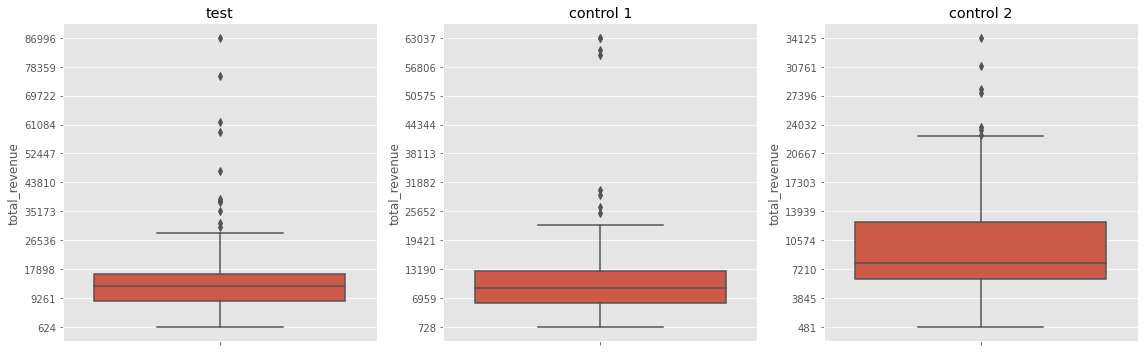

In [84]:
# Определим 99% квантиль
x_q99 = x_full['total_revenue'].quantile(0.99)
y_q99 = y_full['total_revenue'].quantile(0.99)
z_q99 = z_full['total_revenue'].quantile(0.99)

# Отфильтруем данные
x = x_full[x_full['total_revenue'] < x_q99]
y = y_full[y_full['total_revenue'] < y_q99]
z = z_full[z_full['total_revenue'] < z_q99]

display(pd.DataFrame({
    'group': ['test', 'control_1', 'control_2'],
    'corrected_mean': list(map(round, [x.total_revenue.mean(), y.total_revenue.mean(), z.total_revenue.mean()]))
}))

# Визуализируем распределения
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for ax, data, title in zip(ax.flatten(), [x, y, z], ['test', 'control 1', 'control 2']):
    sns.boxplot(data=data, y='total_revenue', ax=ax)
    ax.set(title=title)
    ax.set_yticks(np.linspace(data.total_revenue.min(), data.total_revenue.max(), 11))
plt.tight_layout();

Посколькy выборки у нас независимы, существенные выбросы были "отрезаны" по 99% квантилю, по ЦПТ разность средних значений будет иметь асимптотически нормальное распределение (вне зависимости от распределения выборки):

$$
\bar X_1 - \bar X_2 \overset{asy} {\sim} N \left(0, \frac{\hat s_{1}^2}{n} +  \frac{\hat s_{2}^2}{m}\right)
$$

Критерий для проверки:

$$
Z = \frac{\hat X - \hat Y}{  \sqrt{ \frac{s_{1}^2}{n} + \frac{s_{2}^2}{m} }  }
$$

Сформулируем гипотезы для проверки:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_1 = \mu_2\hspace{2mm} \text{ARPPU для тестовой группы и 1-й контрольной группы равны}\\
&H_1: \hspace{2mm} \mu_1 > \mu_2  \hspace{2mm} \text{в тестовой группе ARPPU выше}
\end{aligned}
$$

In [85]:
# Размер выборок
nx, ny = x.total_revenue.size, y.total_revenue.size

# Разность средних
diff = x.total_revenue.mean() - y.total_revenue.mean()

# Стандартное отклонение
diff_std = np.sqrt(x.total_revenue.var(ddof=1)/nx + y.total_revenue.var(ddof=1)/ny)

# Наблюдаемое значение
z_obs = diff/diff_std

# Значение p-value
p1 = 1 - stats.norm().cdf(z_obs)

# Рассчитаем доверительный интервал
left, right = stats.norm.interval(0.95, loc=diff, scale=diff_std)
delta = round(right) - round(left)
print(f'Доверительный интервал [{round(left)}; {round(right)}] ширины {delta}')

Доверительный интервал [1377; 6266] ширины 4889


'p-value: 0.00109'

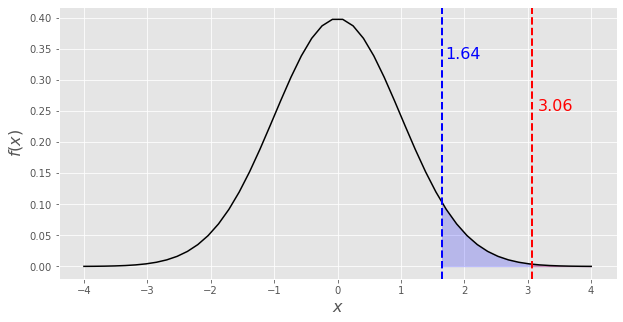

In [86]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger', margin=4)

> Наблюдаемое значение 3.06 больше критического 1.64, следовательно нулевая гипотеза на 5% уровне значимости отвергается.

Сформулируем гипотезы для проверки:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_1 = \mu_3 \hspace{2mm} \text{ARPPU для тестовой группы и 2-й контрольной группы равны}\\
&H_1: \hspace{2mm} \mu_1 > \mu_3  \hspace{2mm} \text{в тестовой группе ARPPU выше}
\end{aligned}
$$

In [87]:
# Размер выборки
nz = z.total_revenue.size

# Разность средних
diff = x.total_revenue.mean() - z.total_revenue.mean()

# Стандартное отклонение
diff_std = np.sqrt(x.total_revenue.var(ddof=1)/nx + z.total_revenue.var(ddof=1)/nz)

# Наблюдаемое значение
z_obs = diff/diff_std

# Значение p-value
p2 = 1 - stats.norm().cdf(z_obs)

# Рассчитаем доверительный интервал
left, right = stats.norm.interval(0.95, loc=diff, scale=diff_std)
delta = round(right) - round(left)
print(f'Доверительный интервал [{round(left)}; {round(right)}] ширины {delta}')

Доверительный интервал [2735; 7212] ширины 4477


'p-value: 6.66e-06'

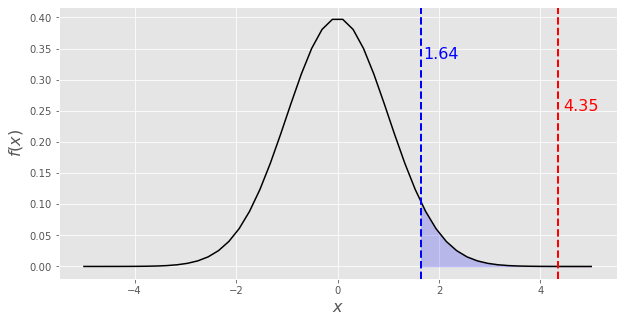

In [88]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger', margin=5)

> Наблюдаемое значение 4.35 больше критического 1.64, следовательно нулевая гипотеза на 5% уровне значимости отвергается.

In [89]:
# Поправка Холма на множественное сравнение 
rejected, p_corrected, _, _ = multipletests([p1, p2], alpha=0.05, method='holm')
print(f'p-values: {p_corrected[0]:.3}, {p_corrected[1]:.3}')

p-values: 0.00109, 1.33e-05


> **Таким образом, гипотеза о равенстве ARPPU по всем продуктам в исследуемых выборках на 5% уровне значимости отвергается:**
>- **ARPPU в тестовой группе превшает ARPPU в 1-й контрольной группе в среднем на $1377 - 6266$ ден. единиц;**
>- **ARPPU в тестовой группе превшает ARPPU в 2-й контрольной группе в среднем на $2735 - 7212$ ден. единиц.**

### 3.4 Гипотеза о равенстве ARPPU по премиум подписке
<br>

Проверим есть ли изменения в ARPPU среди пользователей оформивших премиум подписку.

In [90]:
# Данные по транзацкиям
transactions = [transactions_test, transactions_control_1, transactions_control_2]

# Итоговый датафрейм
arppu_df = pd.DataFrame()

# Преобразование и агрегация данных
for data, group in zip(transactions, ['test', 'control_1', 'control_2']):
    df = data.query('product_type == "premium_no_trial"') \
            .groupby('uid', as_index=False).agg(total=('revenue', 'sum'))
    df['group'] = group    
    arppu_df = pd.concat([arppu_df, df], axis=0, ignore_index=True)
    
arppu_df.head()

,uid,total,group
0,891071157,9100.0,test
1,891152790,12597.0,test
2,891178380,113477.0,test
3,891222282,6292.0,test
4,891291531,4056.0,test


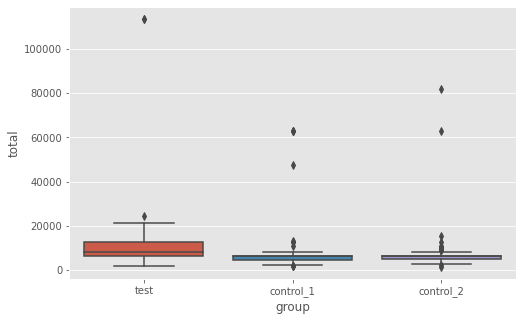

In [91]:
# Посмотрим на распределения по группам
plt.figure(figsize=(8, 5))
sns.boxplot(data=arppu_df, x='group', y='total');

Из распределений видно, что в каждой группе есть выбросы. Будем исходить из вышеозвученной предпосылки о наличии пользователей отличающихся своим поведением. Посмотрим на распределения без учета выбросов.

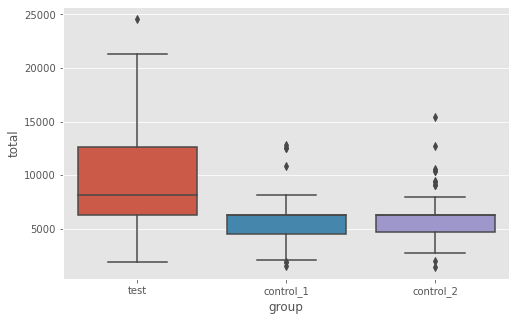

In [92]:
plt.figure(figsize=(8, 5))
data = arppu_df[arppu_df.total < 40000]
sns.boxplot(data=data, x='group', y='total');

Поскольку в анализируемы выборках выбросов не много, срежем их по 99% квантилю и воспользуемся ЦПТ для проверки гипотезы 3.4.

In [93]:
# Посмотрим на центральные характеристики в разрезе групп
arppu_df.groupby('group') \
    .agg(size=('uid','count'),
         mean_total=('total', 'mean'),
         median_total=('total', 'median')) \
    .round()

,size,mean_total,median_total
group,,,
control_1,99,7871.0,6292.0
control_2,102,7302.0,6292.0
test,67,12100.0,8268.0


In [94]:
# Определим 99% квантиль
t_99 = arppu_df[arppu_df.group == 'test'].total.quantile(0.99)
c1_99 = arppu_df[arppu_df.group == 'control_1'].total.quantile(0.99)
c2_99 = arppu_df[arppu_df.group == 'control_2'].total.quantile(0.99)

# Отфильтруем данные
x = arppu_df[(arppu_df.group == 'test') & (arppu_df.total < t_99)]
y = arppu_df[(arppu_df.group == 'control_1') & (arppu_df.total < c1_99)]
z = arppu_df[(arppu_df.group == 'control_2') & (arppu_df.total < c2_99)]

display(pd.DataFrame({
    'group': ['test', 'control_1', 'control_2'],
    'corrected_mean': list(map(round, [x.total.mean(), y.total.mean(), z.total.mean()]))
}))

,group,corrected_mean
0,test,8981
1,control_1,6147
2,control_2,6000


Сформулируем гипотезы для проверки:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_1 = \mu_2\hspace{2mm} \text{ARPPU для тестовой группы и 1-й контрольной группы равны}\\
&H_1: \hspace{2mm} \mu_1 > \mu_2  \hspace{2mm} \text{в тестовой группе ARPPU выше}
\end{aligned}
$$

In [95]:
# Размер выборок
nx, ny = x.total.size, y.total.size

# Разность средних
diff = x.total.mean() - y.total.mean()

# Стандартное отклонение
diff_std = np.sqrt(x.total.var(ddof=1)/nx + y.total.var(ddof=1)/ny)

# Наблюдаемое значение
z_obs = diff/diff_std

# Значение p-value
p1 = 1 - stats.norm().cdf(z_obs)

# Рассчитаем доверительный интервал
left, right = stats.norm.interval(0.95, loc=diff, scale=diff_std)
delta = round(right) - round(left)
print(f'Доверительный интервал [{round(left)}; {round(right)}] ширины {delta}')

Доверительный интервал [1464; 4203] ширины 2739


'p-value: 2.49e-05'

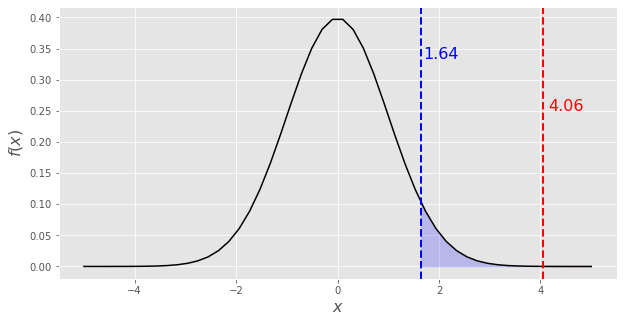

In [96]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger', margin=5)

> Наблюдаемое значение 4.06 больше критического 1.64, следовательно нулевая гипотеза на 5% уровне значимости отвергается.

Сформулируем гипотезы для проверки:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_1 = \mu_3\hspace{2mm} \text{ARPPU для тестовой группы и 2-й контрольной группы равны}\\
&H_1: \hspace{2mm} \mu_1 > \mu_3  \hspace{2mm} \text{в тестовой группе ARPPU выше}
\end{aligned}
$$

In [97]:
# Размер выборки
nz = z.total.size

# Разность средних
diff = x.total.mean() - z.total.mean()

# Стандартное отклонение
diff_std = np.sqrt(x.total.var(ddof=1)/nx + z.total.var(ddof=1)/nz)

# Наблюдаемое значение
z_obs = diff/diff_std

# Значение p-value
p2 = 1 - stats.norm().cdf(z_obs)

# Рассчитаем доверительный интервал
left, right = stats.norm.interval(0.95, loc=diff, scale=diff_std)
delta = round(right) - round(left)
print(f'Доверительный интервал [{round(left)}; {round(right)}] ширины {delta}')

Доверительный интервал [1914; 4049] ширины 2135


'p-value: 2.21e-08'

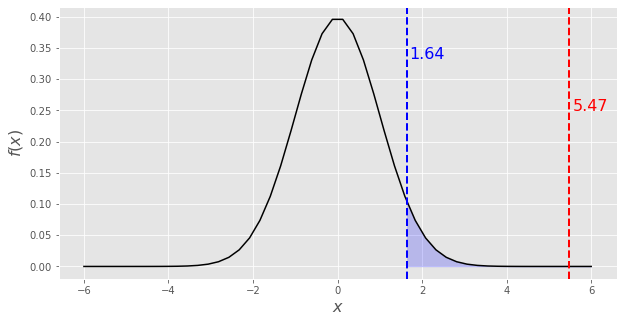

In [98]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger', margin=6)

> Наблюдаемое значение 5.47 больше критического 1.64, следовательно нулевая гипотеза на 5% уровне значимости отвергается.

In [99]:
# Поправка Холма на множественное сравнение 
rejected, p_corrected, _, _ = multipletests([p1, p2], alpha=0.05, method='holm')
print(f'p-values: {p_corrected[0]:.3}, {p_corrected[1]:.3}')

p-values: 2.49e-05, 4.42e-08


> **Таким образом, гипотеза о равенстве ARPPU по премиум подписке в исследуемых выборках на 5% уровне значимости отвергается:**
>- **ARPPU в тестовой группе превшает ARPPU в 1-й контрольной группе в среднем на $1464 - 4203$ ден. единиц;**
>- **ARPPU в тестовой группе превшает ARPPU в 2-й контрольной группе в среднем на $1914 - 4049$ ден. единиц.**

### 3.5 В поисках различий групп пользователей

Сперва посмотрим какие страны встречаются во всех трех группах для пользователей оформивших премиум подписку.

In [100]:
# Создадим множества уникальных стран для каждой выборки
t = set(transactions_test.query('product_type == "premium_no_trial"').country.tolist())
c1 = set(transactions_control_1.query('product_type == "premium_no_trial"').country.tolist())
c2 = set(transactions_control_2.query('product_type == "premium_no_trial"').country.tolist())

# Посмотрим на пересечение стран для всех выборок
common_countries = t.intersection(c1).intersection(c2)
common_countries

{'Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'France',
 'Germany',
 'Israel',
 'Italy',
 'Spain',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America'}

Посмотрим какие страны есть в тестовой группе но отсутствуют в контрольных группах.

In [101]:
print(f'Разница в странах между тестовой и 1-й контрольной группой: {t.difference(c1)}')
print(f'Разница в странах между тестовой и 2-й контрольной группой: {t.difference(c2)}')
print(f'Разница в странах между 1-й и 2-й контрольной группами: {c1.difference(c2)}')

Разница в странах между тестовой и 1-й контрольной группой: {'Mexico', 'Latvia'}
Разница в странах между тестовой и 2-й контрольной группой: {'Turkey', 'Mexico', 'Latvia'}
Разница в странах между 1-й и 2-й контрольной группами: {'India', 'Turkey'}


**Можем предположить, что изменение стоимости подписки было положительным для пользователей из Латвии и Мексики.**
<br>

Для начала посмотрим есть ли разница для пользователей оформивших премиум подписку в разрезе различных стран. Отфильтруем данные и заменим длинные названия стран на сокращенные, объединим данные в одни датасет. В качестве метрики будем использовать **`AOV` - средний чек транзакции.**

In [102]:
# Создадим словарь для переименования стран
mapping = {'United States of America': 'USA', 'United Kingdom (Great Britain)': 'UK', 'United Arab Emirates': 'UAE',
           'Russian Federation': 'Russian'}

# Итоговый датафрейм
premium_df = pd.DataFrame()

# Преобразование и агрегация данных
for data, group in zip(transactions, ['test', 'control_1', 'control_2']):
    df = data.query('country in @common_countries & product_type == "premium_no_trial"') \
            .groupby(['uid', 'country'], as_index=False).agg(aov=('revenue', 'mean'))
    
    df['country'] = df.country.apply(lambda x: mapping.get(x) if x in mapping else x)
    df['group'] = group
    premium_df = pd.concat([premium_df, df], axis=0, ignore_index=True)
    
premium_df.head()

,uid,country,aov,group
0,891071157,USA,9100.0,test
1,891152790,Spain,12597.0,test
2,891178380,Spain,113477.0,test
3,891222282,USA,6292.0,test
4,891291531,Germany,4056.0,test


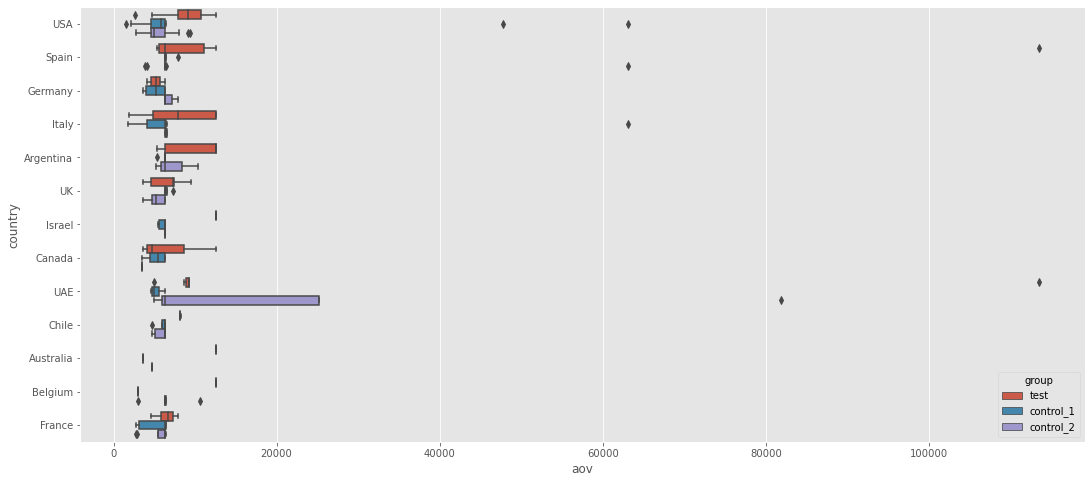

In [103]:
# Посмотрим на распределения в разрезе стран
plt.figure(figsize=(18, 8))
sns.boxplot(data=premium_df, y='country', x='aov', hue='group');

Из графика видно, что средний чек покупки среди пользователей оформивших премиум подписку в ряде стран превосходит 40 000 ден. единиц.<br>

Сделаем сводную таблицу по странам со средним и медианным значением `AOV`

In [104]:
premium_df.groupby(['group', 'country'], as_index=False) \
        .agg(group_size=('uid', 'count'),
             mean_aov=('aov', 'mean'),
             median_aov=('aov', 'median')) \
        .pivot(index='country', columns='group', values=['group_size', 'mean_aov', 'median_aov'])
#         .style \
#         .background_gradient(cmap='cividis') \
#         .format('{:.6}')

agg_premium.round()

NameError: name 'agg_premium' is not defined

Анализ сводной таблицы показывает, что выборки в разрезе стран получились очень маленькими. Для Австралии на каждую группу приходится по одному пользователю.<br>

Поскольку выборки получились очень маленькие целесообразно воспользоваться `бутстрапом`, таким образом мы попытаемся приблизить истинное распределение эмпирическим. Предположим, что бутстрап распределение окажется похожим на реальное распределение.


Наряду с бутстрапом воспользуемся также и непараметрическим критерием `Манна-Уитни`. Применение теста Манна-Уитни требует выполнение предпосылки об одинаковом распределении сравниваемых выборок и разница между ними есть только в том, что одна из них сдвинута по отношению ко второй. Для проверки допущения о том, что две выборки пришли из одного распределения воспользуемся тестом Колмогорова-Смирнова.<br>

Выборки где есть только одно наблюдение сравнивать не будем.

Проверим следующие гипотезы:

Бутстрап для медиан:
\begin{equation*}
\begin{aligned} 
& H_0: Me_{test} = Me_{control}  \\
& H_a: Me_{test} \ne Me_{control}
\end{aligned}
\end{equation*}


Тест Манна-Уитни для распределений:
\begin{equation*}
\begin{aligned} 
& H_0: f_{X}(x) = f_{Y}(x)  \\
& H_a: f_{X}(x) = f_{Y}(x \pm \Delta), \Delta \ne 0
\end{aligned}
\end{equation*}

In [ ]:
contries = premium_df.country.unique().tolist()
p1_vals = {}
p2_vals = {}

for name in contries:
    test = premium_df[(premium_df.country == name) & (premium_df.group == 'test')].aov
    control_1 = premium_df[(premium_df.country == name) & (premium_df.group == 'control_1')].aov
    control_2 = premium_df[(premium_df.country == name) & (premium_df.group == 'control_2')].aov
    if min([test.size, control_1.size, control_2.size]) >= 2:
        boot1_p = get_bootstrap(test, control_1, statistic=np.median)
        mw1_p = stats.mannwhitneyu(test, control_1, alternative='two-sided')[-1]
        ks1_p = stats.ks_2samp(test, control_1)[-1]
        p1_vals[name] = [boot1_p, mw1_p, ks1_p]
        
        boot2_p = get_bootstrap(test, control_2, statistic=np.median)
        mw2_p = stats.mannwhitneyu(test, control_2, alternative='two-sided')[-1]
        ks2_p = stats.ks_2samp(test, control_2)[-1]
        p2_vals[name] = [boot2_p, mw2_p, ks2_p]
    else:
        continue
        
p_res = pd.concat([pd.DataFrame(p1_vals).T.rename(columns={0: 'boot_c1', 1: 'mw_c1', 2: 'ks_c1'}),
                   pd.DataFrame(p2_vals).T.rename(columns={0: 'boot_c2', 1: 'mw_c2', 2: 'ks_c2'})],
                  axis=1)

In [ ]:
p_res.round(6)

Из результатов проверки гипотез видно, что для тех выборок где допущение об одинаковом распределении удовлетворяется, нулевая гипотеза не отвергается - статистически значимых различий между сравниваемыми группами обнаружить не удалось.<br>

Для выборок не удовлетворяющих предпосылке об одинаковом распределении будем полагаться на результаты бутстрапа. Сделаем поправку значений `p-value` на множественное сравнение для тестовых групп.

In [ ]:
# Поправка Холма на множественное сравнение тестовая группа - 1-я контрольная группа
rejected, p_corrected, _, _ = multipletests(p_res.boot_c1.values, alpha=0.05, method='holm')
msk_1 = np.array(p_corrected) < 0.05
p_res['boot_c1'][msk_1]

In [ ]:
# Поправка Холма на множественное сравнение тестовая группа - 2-я контрольная группа
rejected, p_corrected, _, _ = multipletests(p_res.boot_c2.values, alpha=0.05, method='holm')
msk_2 = np.array(p_corrected) < 0.05
p_res['boot_c2'][msk_2]

> **Таким образом, на 5% уровне значимости:**
>- **медианное значение `среднего чека транзакции` в тестовой группе статистически значимо различается с 1-й
контрольной группой для следующих стран: `США`, `Израиль` и `Чили`;**
>- **медианное значение `среднего чека транзакции` в тестовой группе статистически значимо различается с 2-й
контрольной группой для `США` и `Чили`.**

**Посмотрим, есть ли у нас различия для пользователей оформивших премиум подписку в зависимости от возраста.**<br>

Проверим следующие гипотезы для различных возрастных групп:

Бутстрап для медиан:
\begin{equation*}
\begin{aligned} 
& H_0: Me_{test} = Me_{control}  \\
& H_a: Me_{test} \ne Me_{control}
\end{aligned}
\end{equation*}


Тест Манна-Уитни для распределений:
\begin{equation*}
\begin{aligned} 
& H_0: f_{X}(x) = f_{Y}(x)  \\
& H_a: f_{X}(x) = f_{Y}(x \pm \Delta), \Delta \ne 0
\end{aligned}
\end{equation*}

In [ ]:
# Данные по пользователям
users = [users_test, users_control_1, users_control_2]

# Итоговый датафрейм
age_df = pd.DataFrame()

# Преобразование и агрегация данных
for data_t, data_u, group in zip(transactions, users, ['test', 'control_1', 'control_2']):
    df_t = data_t.query('product_type == "premium_no_trial"') \
            .groupby('uid', as_index=False).agg(aov=('revenue', 'mean'))
    df_t['group'] = group
    
    data_u['age_bins'] = pd.cut(data_u['age'], bins=[15, 20, 25, 30, 35, 40, 45, 100],
                                labels=['15-20', '20-25', '25-30', '30-35', '35-40', '40-45', 'above 45'])
    
    df_u = data_u[['uid', 'age_bins', 'country']]
    merged = df_t.merge(df_u, on='uid', how='left')
    
    age_df = pd.concat([age_df, merged], axis=0, ignore_index=True)
    
age_df.head()

In [ ]:
# Посмотрим на распределения в разрезе возраста
plt.figure(figsize=(18, 8))
sns.boxplot(data=age_df, y='age_bins', x='aov', hue='group');

Сделаем сводную таблицу по возрастным группам со средним и медианным значением `AOV`

In [ ]:
age_df.groupby(['group', 'age_bins'], as_index=False) \
        .agg(group_size=('uid', 'count'),
             mean_aov=('aov', 'mean'),
             median_aov=('aov', 'median')) \
        .pivot(index='age_bins', columns='group', values=['group_size', 'mean_aov', 'median_aov']) \
        .style \
        .background_gradient(cmap='cividis') \
        .format('{:.6}')

Выполним необходимые преобразования и вычисления для проверки гипотез.

In [ ]:
bins = sorted(age_df.age_bins.unique().tolist())
p1_vals2 = {}
p2_vals2 = {}

for age in bins:
    test = age_df[(age_df.age_bins == age) & (age_df.group == 'test')].aov
    control_1 = age_df[(age_df.age_bins == age) & (age_df.group == 'control_1')].aov
    control_2 = age_df[(age_df.age_bins == age) & (age_df.group == 'control_2')].aov

    boot1_p = get_bootstrap(test, control_1, statistic=np.median)
    mw1_p = stats.mannwhitneyu(test, control_1, alternative='two-sided')[-1]
    ks1_p = stats.ks_2samp(test, control_1)[-1]
    p1_vals2[age] = [boot1_p, mw1_p, ks1_p]
        
    boot2_p = get_bootstrap(test, control_2, statistic=np.median)
    mw2_p = stats.mannwhitneyu(test, control_2, alternative='two-sided')[-1]
    ks2_p = stats.ks_2samp(test, control_2)[-1]
    p2_vals2[age] = [boot2_p, mw2_p, ks2_p]

        
p_res2 = pd.concat([pd.DataFrame(p1_vals2).T.rename(columns={0: 'boot_c1', 1: 'mw_c1', 2: 'ks_c1'}),
                   pd.DataFrame(p2_vals2).T.rename(columns={0: 'boot_c2', 1: 'mw_c2', 2: 'ks_c2'})],
                  axis=1)

In [ ]:
p_res2.round(6)

In [ ]:
# Поправка Холма на множественное сравнение тестовая группа - 1-я контрольная группа
rejected, p_corrected, _, _ = multipletests(p_res2.boot_c1.values, alpha=0.05, method='holm')
msk_1 = np.array(p_corrected) < 0.05
p_res2['boot_c1'][msk_1]

In [ ]:
# Поправка Холма на множественное сравнение тестовая группа - 2-я контрольная группа
rejected, p_corrected, _, _ = multipletests(p_res2.boot_c2.values, alpha=0.05, method='holm')
msk_2 = np.array(p_corrected) < 0.05
p_res2['boot_c2'][msk_2]

> **Таким образом, на 5% уровне значимости медианное значение `среднего чека транзакции` в тестовой группе статистически значимо различается с 1-й и 2-й контрольной группами для пользователей в возрасте от 20 до 30 лет и пользователей с возрастом больше 45 лет.**

<hr>

## 4. Заключение

Оценка эффективности АА/Б теста осуществлялась по следующим метрикам:


| Метрики          |  Тестовая группа           | 1-я контрольная группа | 2-я контрольная группа |
| :----------------| :--------------------------|:-----------------------| :----------------------|
| Долья пользоваталей совершивших покупку                          | 3,39%    | 4,45%   | 4,39%   |
| Долья пользоваталей совершивших покупку по премиум подписке      |  42,8%   | 34,7%   | 28,3%   |
| ARPPU по всем продуктам (корректированное значение)              | 14 436   | 10 615  | 9 462   |
| ARPPU по премиум подписке (корректированное значение)            | 8 981    | 6 147   | 6 000   |

Результаты проведенного анализа позволяют сделать вывод об успешности эксперимента. Несмотря на то что доля пользователей совершивших покупку в тестовой группе снизилась по сравнению с долей пользователей как в 1-й контрольной группе, так и во 2-й контрольной группе, доля пользователей оформивших премиум подписку в тестовой группе увеличилась по сравнению со 2-й контрольной группой на величину лежащую в диапозоне от 3.16% до 23.72% (статистически значимой разницы между тестовой и 1-й контрольной группой обнаружить не удалось). 

Статистически значимо увеличился ARPPU по всем продуктам в тестовой группе:
 - в среднем на $1377 - 6266$ ден. единиц по сравнению с 1-й контрольной группой;
 - в среднем на $2735 - 7212$ ден. единиц по сравнению с 2-й контрольной группой.


Статистически значимо увеличился ARPPU по **премиум подписке** в тестовой группе:
- в среднем на $1464 - 4203$ ден. единиц по сравнению с 1-й контрольной группой;
- в среднем на $1914 - 4049$ ден. единиц по сравнению с 2-й контрольной группой.
<br>

Анализ пользователей в разрезе различных групп позволяет сделать вывод, что нововведение имеет смысл:
- для пользователей из США, Израиля и Чили (медианное значением среднего чека транзакции в тестовой группе статистически значимо увеличилось по сравнению с контрольными группами);
- возможно для пользователей из Австралии и Бельгии (однозначный вывод сделать сложно, т.к. в выборках по этим странам всего по одному наблюдению, за исключением Бельгии во 2-й контрольной группе (5 наблюдений));
- можно также предположить что изменение стоимости премиум-подписки при покупке через две новые платежные системы положительно повлияло на пользователей из Латвии и Мексики (пользователи из этих стран оформили премум подписку в тестовой группе, а в контрольных группах нет);
- для пользователей в возрасте от 20 до 30 лет и пользователей с возрастом больше 45 лет (медианное значением среднего чека транзакции в тестовой группе статистически значимо изменилось по сравнению с контрольными группами).

### [⬅ Содержание](#Содержание)